#  Dynamic Hedging and Replication - Derivatives
Alexandru Giurca, November 2019

#### Summary

In this project I will implement a self-financing dynamic hedging strategy that replicates the payoff of different derivative contracts. Due to the random nature of the asset subject to the contracts tested, it will be modeled as a stochastic process. Once the model has been implemented, a series of simulations will be carried out to study the effectiveness of the strategy.

## 1. Introduction
In this session I give a brief description of what a SDE is and state the problem that will be addressed.

### 1.1. Task

Due to the inherent uncertainty in the financial market, it is necessary to take into account a random fluctuation in the models created to describe different instruments. For this purpose, the behavior of an asset is often assumed to be a stochastic process. The development of the modelling object (e.g. share price, number of people arriving at a hospital, etc.), is described by a Stochastic Differential Equation (SDE).

Consider an asset whose price dynamics satisfy the following SDE:

$$\frac{\mathrm{d} S_t}{S_t}=\mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}$$

A derivative with a European characteristic has a payoff described by any function $V_T = V(T, S_T) $, where $T$ is the maturity of the derivative and $S_T$ the price of the underlying asset in $T$. We assume that we can trade any amount of it at any time. There are no transaction costs (brokerage, fee, bid-ask spread, etc.) involved and short positions in the underlying are allowed - with no associated costs.

I want to implement **dynamic, self-financing hedging strategy** that replicates the payoff of the derivative sold. The replicating strategy will be rebalanced $N$ times (including the initial portfolio).

The simulation is performed for the following payoffs,with $ K $ being the option Strike.
- $V(T, S_T)=ln(S_T)$
- $V(T, S_T)=(ln(S_T))^2$
- $V(T, S_T)=(S_T-K)^2$
- $V(T, S_T)=\mathbf{1}_{S_T > K}$
- $V(T, S_T)=max(S_T-K, 0)$


## 2. Simulating the underlying asset

To perform the simulation, I will implement the stochastic process of the underlying asset, which follows a  Geometric Brownian Motion. In this way, I need to discretize the process. Two options are possible: find the solution for the proposed SDE, which will result in the desired stochastic process; or use Euler's method. The latter, despite being only an approximation of the process, has the advantage that it can be applied to any Stochastic differential equation. In the next subsections I will demonstrate and implement each model.

### 2.1. The Analytical Model Solution

Rewriting the dynamics

\begin{equation}
    \begin{aligned}
    \frac{\mathrm{d} S_t}{S_t} &= \mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}
    \end{aligned}
\end{equation}


which corresponds to the stochastic integral

\begin{equation}
    \begin{aligned}
    \int_{t}^{T}{\frac{\mathrm{d} S_t}{S_t}} &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} 
    \end{aligned}
\end{equation}

Using Ito's Lemma we obtain

\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) = \frac{\mathrm{\partial} f}{\partial t} \mathrm{d} t + \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2
    \end{aligned}
\end{equation}

Applying Ito's Lemma on $ f(S_t) = ln(S_t) $ results is
\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) &= \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2 \\
    &= \frac{1}{S_t} \cdot \mathrm{d} S_t - \frac{\sigma^2}{2} \cdot S_{t}^{2} \cdot \frac{1}{S_{t}^{2}} \cdot  \mathrm{d} t 
    \end{aligned}
\end{equation}

Then

\begin{equation}
    \begin{aligned}
    \int_{t}^{T} \mathrm{d} f(t, S_t) &= \int_{t}^{T} \frac{1}{S_t} \cdot \mathrm{d} S_t - \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    \int_{t}^{T} \frac{\mathrm{d} S_t}{S_t} &= \int_{t}^{T} \mathrm{d} f(t, S_t) + \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    &= f(S_T) - f(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T) - ln(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t)
    \end{aligned}
\end{equation}

Therefore, replacing this result in the stochastic integral leads to

\begin{equation}
    \begin{aligned}
    ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} \\
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot (W_{T} - W_{t})
    \end{aligned}
\end{equation}

Finally, remembering that $W_t$ is a Winer process and has independent, stationary increments and distributed $N(0,t) $ by definition I end up with
\begin{equation}
    \begin{aligned}
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot W_{T-t} \\
     ln(S_T/S_t) &= \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t} \\
     S_T &= S_t \cdot e^{ \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t}}
    \end{aligned}
\end{equation}

Where $ W_ {T-t} = \sqrt{T-t} \cdot \epsilon_t $. The last equation is the analytical solution of this SDE and could be used in the simulation. Below, I will implement and test it.

In [47]:
# necessary packages
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings("ignore")

In [9]:
class StochasticProcess(object):
    '''
    A general representation of a Stochastic Process
    '''
    def __init__(self, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a StochasticProcess object. Save all parameters as attributes
        '''
        self._f_sigma = 0
        # parameters
        self.f_sigma = f_sigma
        self.f_time = f_time
        self.f_steps = f_steps
        self.b_random_state = b_random_state
        # checks whether to set a seed for the random state
        if not b_random_state:
            np.random.seed(0)
    
    @property
    def f_sigma(self):
        '''
        Return the variance of the process
        '''
        return self._f_sigma
    
    @f_sigma.setter
    def f_sigma(self, f_value):
        '''
        set the f_sigma attribute. ensure that the number is positive
        :param f_value: float. A non negative float number
        '''
        # TODO: I need to check this property
        assert f_value>=0., "Volatility must be positive"
        self._f_sigma = f_value
        
    def _random_number(self):
        '''
        Return a float drown from a distribution
        and standard deviation 1
        '''
        raise NotImplementedError()
    
    def __call__(self):
        '''
        Return a random drow from the Stochastic Process
        '''
        raise NotImplementedError()
    

In [10]:
class WienerProcess(StochasticProcess):
    '''
    A representation of a Wiener process, also called Brownian motion.
    '''
    def __init__(self, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a WienerProcess object. Save all parameters as attributes
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        super(WienerProcess, self).__init__(f_sigma, f_time, f_steps, b_random_state = True)
    
    def _random_number(self):
        '''
        Return a float of drown from a normal distribution with mean 0 and standard
        deviation 1
        '''
        return np.random.standard_normal()
    
    def __call__(self):
        '''
        Return a random drow from the Wiener process with mean 0 and variance t
        '''
        delta_t = self.f_time/self.f_steps
        sqrt_delta_sigma = math.sqrt(delta_t) * self.f_sigma
        return sqrt_delta_sigma * self._random_number()

In [11]:
class GeometricBrownianMotion(StochasticProcess):
    '''
    A generic representation of a Geometric Brownian Motion (GBM). Besides de variance,
    this process might present a drift
    '''
    def __init__(self, f_s0, f_sigma, f_time, f_steps, b_random_state=True, f_r=None, f_mu=None):
        '''
        Initialize a GeometricBrownianMotion object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        :*param f_r: float. risk free interest rate
        :*param f_mu: float. the average return of the process
        '''
        # initiate parameters
        self._original = f_s0
        self.f_St = f_s0
        self.f_mu = f_mu
        self.f_r = f_r
        self._current_step = -1
        super(GeometricBrownianMotion, self).__init__(f_sigma, f_time, f_steps,
                                                      b_random_state = True)
        # initiate Wiener Process
        self.wiener_process = None
  
    @property
    def current_step(self):
        '''
        Return the variance of the process
        '''
        return self._current_step
    
    @current_step.setter
    def current_step(self, i_value):
        '''
        set the current_step attribute. ensure that the current step is
        not greater than the total steps defined to the process
        :param i_value: integer. A increment step to the current path
        '''
        self._current_step = i_value
        if self._current_step > self.f_steps:
            self._current_step = 0
            self.f_St = self._original
        
        
    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        raise NotImplementedError()

In [12]:
class GBM_Exact_Solution(GeometricBrownianMotion):
    '''
    A representation of the Exact solution of a Geometric Brownian Motion (GBM).
    Besides de variance, this process might present a drift
    '''
    def __init__(self, f_s0, f_mu, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_mu: float. the average return of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # initiate parameters of GeometricBrownianMotion
        super(GBM_Exact_Solution, self).__init__(f_s0 = f_s0,
                                                 f_mu = f_mu,
                                                 f_sigma = f_sigma,
                                                 f_time = f_time,
                                                 f_steps = f_steps,
                                                 b_random_state = True)
        # initiate WinnerProcess
        self.wiener_process = WienerProcess(f_sigma, f_time, f_steps)      
        
    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by the
        Exact solution of the Geometric Brownian Motion
        '''
        # number of steps already taken by this process: when greater than limit, returns to initial state and start again
        self.current_step += 1
        s_entry = "Not"
        
        if self.current_step > 0:
            s_entry = "Sim"
            # calculates price by Geometric Brownian Motion
            dt = self.f_time/self.f_steps
            sigma_pow_mu_delta = (self.f_mu - 0.5 * self.f_sigma**2.0) * dt
            f_log_rtn = sigma_pow_mu_delta + self.wiener_process()
            f_rtn = np.exp(f_log_rtn)
            self.f_St *= f_rtn
            # print(self.current_step, self.f_St, s_entry
        return self.f_St

In [13]:
import time

def do_simulations(MyStochasticProcess, i_nsiml, f_s0, f_mu, f_sigma, f_time, f_steps, f_r=None):
    '''
    Simulate a number of paths using some Stochastic Process and return a dataframe
    with all paths
    :param MyStochasticProcess: StochasticProcess object. The stochastic process used
    :param i_nsiml: integer. the number of paths contructed
    :param f_s0: float. The initial price of the process
    :param f_mu: float. the average return of the process
    :param f_sigma: float. The standard deviation of ALL distribution
    :param f_time: float. the time at each step, in years
    :param f_steps: float. number of steps to simulate for
    '''
    st = time.time()
    
    if f_r:
        gbm = MyStochasticProcess(f_s0=f_s0,
                                 f_r=f_r,
                                 f_sigma=f_sigma,
                                 f_time=f_time,
                                 f_steps=f_steps)
    else:
        gbm = MyStochasticProcess(f_s0=f_s0,
                                 f_mu=f_mu,
                                 f_sigma=f_sigma,
                                 f_time=f_time,
                                 f_steps=f_steps)
    # create i_nsiml paths with f_steps simulations
    l = []
    l_aux = []
    for idx in range(int(i_nsiml * (1 + gbm.f_steps))):
        if gbm.current_step==gbm.f_steps:
            l.append(l_aux)
            l_aux = []
        l_aux.append(gbm())
    l.append(l_aux)
    # print time and simulations
    print ("\n Number: {}".format(idx + 1))
    print ("It took {:0.2f} seconds".format(time.time() - st))
    # create dataframe with steps in rows and simulations in columns
    df = pd.DataFrame(l).T
    return df

In [14]:
def plot_simulations(df, s_title, f_steps):
    '''
    Plot a line chart to each path in the dataframe passed
    and a vertical histogram summarizing all paths
    :param df: dataframe. the data with all paths simulated
    :param s_title: string. The title of the chart
    :param f_steps: float. the number of steps in the simulation
    '''
    # create grid
    sns.set_context(rc={"figure.figsize": (15, 6)})
    g = sns.JointGrid(x=df.columns, y=df.iloc[-1, :].values, height=7)
    g.ax_marg_x.set_visible(False)
    # plot lines
    g.ax_joint.plot(df, linewidth=2)
    g.ax_joint.set_xlim([0, int(f_steps)])
    # ploto histograms
    g.plot_marginals(sns.distplot, kde=True)
    # fix the graph
    g.fig.suptitle(s_title, fontsize=18, y=0.92)
    g.set_axis_labels("Step", "Price");

Below I will plot 500 paths, each with 15 steps. I will visually show the first lines of the matrix created to check:

In [15]:
d_param = {"f_s0": 10.,  # initial state of the asset
           "f_mu": 0.25,  # average for dynamics
           "f_sigma": 0.15,  # standard deviation for dynamics
           "f_time": 0.5,  # time elapsed in the simulation
           "f_steps": 15, # number of steps taken between a and f_time
           "f_r": None  # interest rate
           }  
df = do_simulations(GBM_Exact_Solution, 500, **d_param)
df.head()


 Number: 8000
It took 0.07 seconds


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,10.398908,9.592302,10.191620,9.965687,10.641888,9.580075,10.353335,10.446672,9.843948,10.113153,...,10.483106,10.114747,10.838726,10.078238,9.682032,10.036841,9.992244,10.381685,10.051417,9.855439
2,10.594752,9.398858,9.964769,9.861084,10.978773,9.473500,10.300337,10.809182,9.949890,10.049995,...,10.696285,9.949877,11.082279,10.101997,10.080636,9.984490,10.117262,10.534212,10.353320,10.359734
3,10.231910,9.529866,10.264254,9.646288,11.005097,9.548009,10.325617,10.864713,9.927660,10.539751,...,10.977218,9.889459,11.558581,10.272507,9.845429,10.151744,10.042360,10.945895,10.843254,10.566695
4,10.474995,9.373973,10.740923,9.852951,11.184292,9.366460,10.091737,11.047547,9.755867,10.542747,...,10.746062,10.104799,11.894681,10.003458,10.392258,9.842194,10.353988,10.949189,10.334776,10.754889


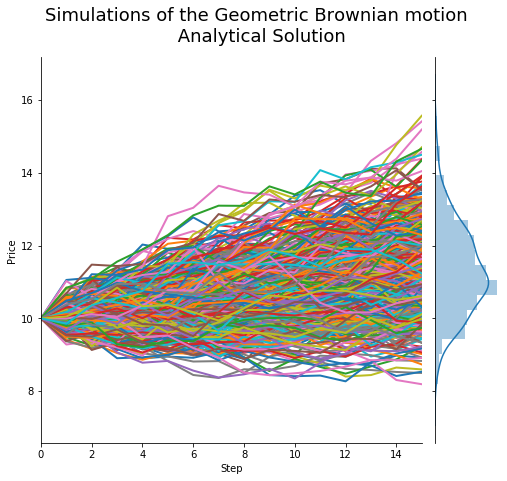

In [16]:
plot_simulations(df,
                 "Simulations of the Geometric Brownian motion \n Analytical Solution",
                 d_param["f_steps"])

In [17]:
# shows statistical summary of the last value (in T) of the simulations
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500.0,11.31448,1.230825,8.190736,10.462814,11.17376,12.137254,15.566199


Apparently the implementation was correct and, despite being simulating one step at a time and dividing the entire process into different steps, the time required to run the entire simulation was at an acceptable level (about 80 milliseconds). Below, I will use the entire structure created in this subsection to do the simulation using the Euler method.


### 2.2. Approximation Using the Euler Method

In real applications, the stochastic equation may often not have an explicit solution or we may have difficulty determining the model parameters and/or the distribution of $ W_{t}$. Thus, Euler's method is often used to discretize the process. In this case, the method is of the form:

\begin{equation}
    \begin{aligned}
    \hat{X}_{t_{i+1}} = \hat{X}_{t_{i}} + b(t, \hat{X}_{t_i}) \cdot h_i + \sigma(t_i, \hat{X}_{t_i}) \cdot \sqrt{h_i} \cdot \epsilon_i\\
    \left\{\begin{matrix}
        b(t, \hat{X}_{t_i}) &= \mu S_{t_{i}}\\ 
        \sigma(t_i, \hat{X}_{t_i}) &= \sigma S_{t_{i}}\\ 
        h_i &= t_{i+1} - t_i
    \end{matrix}\right.
    \end{aligned}
\end{equation}

$\epsilon $ is a random variable with a standard normal distribution. Below I will implement and test this method:

In [18]:
class GBM_By_Euler(GeometricBrownianMotion):
    '''
    A representation of the Geometric Brownian Motion (GBM) simulated using Euler
    Method. Besides de variance, this process might present a drift
    '''
    def __init__(self, f_s0, f_mu, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_mu: float. the average return of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # initiate parameters of GeometricBrownianMotion
        super(GBM_By_Euler, self).__init__(f_s0=f_s0,
                                           f_mu=f_mu,
                                           f_sigma=f_sigma,
                                           f_time=f_time,
                                           f_steps=f_steps)
        # initiate WienerProcess
        self.sigma_sqrt_t_eps = WienerProcess(f_sigma, f_time, f_steps)

    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        # set the number of steps already taken by this process: if > limit, returns to initial state and start again
        self.current_step += 1
        if self.current_step > 0:
            # calculates price by geometric Brownian motion
            dt = self.f_time/self.f_steps
            mu_St_dt = self.f_mu * self.f_St * dt
            sigma_St_sqrt_t_eps = self.f_St * self.sigma_sqrt_t_eps()
            self.f_St += mu_St_dt + sigma_St_sqrt_t_eps
            # print(self.current_step, self.f_St, s_entry)
        return self.f_St

Performing the test with the same parameters as the previous simulation, I obtain the following results:

In [19]:
d_param = {"f_s0": 10.,  # initial state of the asset
           "f_mu": 0.25,  # average for dynamics
           "f_sigma": 0.15,  # standard deviation for dynamics
           "f_time": 0.5,  # time elapsed in the simulation
           "f_steps": 15, # number of steps taken between a and f_time
           "f_r": None  # interest rate
           }  
df = do_simulations(GBM_By_Euler, 500, **d_param)
df.head()


 Number: 8000
It took 0.04 seconds


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,9.731951,9.957777,10.524847,10.366077,9.972823,10.418027,10.041498,10.063972,10.214405,9.979090,...,10.066351,10.307252,9.878955,10.233691,10.137016,10.203912,10.475805,10.123388,10.186188,9.859397
2,9.477673,10.236163,10.538169,10.303591,9.894849,10.252570,10.026626,9.876214,10.049628,10.011348,...,10.367766,10.294296,9.837123,10.251528,10.234083,10.022423,10.710194,10.382862,10.356450,10.203639
3,9.391262,10.178206,11.004038,10.642641,9.885500,10.668171,9.917300,10.170643,10.215405,9.759638,...,11.270547,10.486291,10.227797,10.157166,10.776819,10.169399,10.502091,10.750446,10.717391,9.927089
4,9.285910,9.987035,11.473527,10.449680,10.333328,10.938583,9.864549,10.419121,9.930929,9.822398,...,11.346456,10.709681,10.688629,10.507648,11.284235,10.533557,10.448348,10.977624,10.995912,9.985877


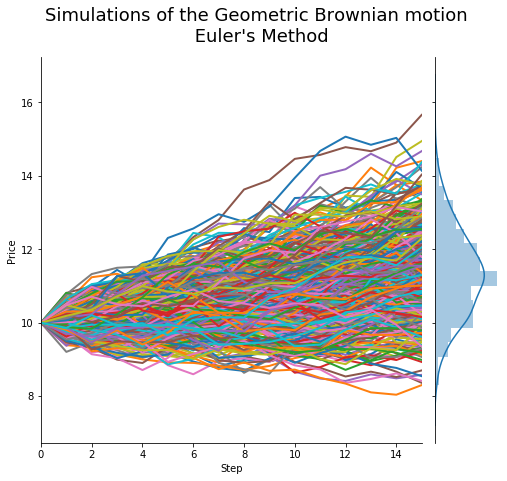

In [20]:
plot_simulations(df,
                 "Simulations of the Geometric Brownian motion \n Euler's Method",
                 d_param["f_steps"])

In [21]:
# shows statistical summary of the last value (in T) of the simulations
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500.0,11.337535,1.195952,8.301533,10.483168,11.296133,12.093096,15.659191


The final distribution of the values is sufficiently similar and this method is much more generic and easier to use than solving an EDE. In addition, this simulation was slightly faster than the previous one. I will use Euler's method when implementing the replication strategy. An interesting point to note in the simulations is that they were shifted up a little because there is a drift in the dynamics, represented by $ \mu $.

## 3. Pricing Options

The fair value of an option can be seen as the expected payoff at maturity(asset prices and hence asset pricing models reflect the arbitrage-free price of the asset as any deviation from this price will be "arbitraged away"). However, not the value under the real expectation, which considers the real (and generally unknown) probability of different events happening, but the risk-neutral:

$$Option \ Price = e^{-r(T-t)} \cdot \tilde{\mathbb{E}}[payoff(S_T)]$$

Where $e^{-r(T-t)}$ is a discount factor. In this section I will briefly demonstrate some important concepts Martingale Pricing and implement the classes necessary to calculate the price of each desired option. 

### 3.1. Martingale and No-Arbitration

It is said that a given sequence of random variables is a Martingale when, at a given moment, the expectation about its next value is the value observed at that moment. Therefore, a process is martingale if

$$M_n = \mathbb{E}_n [M_{n+1}],\qquad n = 0, 1, ..., N-1$$

When pricing an option, it is interesting that its underlying has this characteristic as this is the equivalent of saying that it is not possible to carry out arbitrage using the priced option and the asset on which it is based.

As observed in the simulations, the average of the dynamics was slightly shifted from its original value. This was because his expectation was given for $ \mathbb{E}^{P}[S_t] = S_0 e^{(\mu - \tfrac{\sigma^2}{2})t} $, where $P$ denotes that the real probability is being used (remembering that $\mathbb{E}[W_t] = 0$). Thinking about non-arbitrage, it is necessary to find a way to change the dynamics drift to $r$. Thus, when the price is brought to present value, a Martingale will be obtained.

### 3.2. Measure Change

In order to make the necessary measure change, **Girsanov's Theorem** is used:

$$\mathrm{d} \tilde{W_t} = \mathrm{d} W_t - X_t \mathrm{d}t$$

Where $ \mathrm{d} W_t $ is a Wiener process with respect to the $ P $ probability measure and $ \mathrm{d}\tilde{W_t} $ is martingale with respect to the $ \tilde{P} $ measure. The random variable $ X $ is any function. 

Thus

$$\tilde{P}(A) = \mathbb{E}^{P}[1_A \xi_{t}] = \int_{\Omega}^{} 1_A \xi_t \mathrm{d} P = \int_{A}^{} \xi_t \mathrm{d} P$$

and

$$\mathrm{d} \tilde{P} = \xi \mathrm{d} P \Rightarrow \xi_t = \frac{\mathrm{d} \tilde{P}}{\mathrm{d} P}$$

Where $ \xi_t $ is the Radon-Nikodym derivative. Important in this demonstration is to show that the probability measures are equivalent. So, note that:

$$\mathbb{E}^{P}[\xi_t X] = \int_{\Omega} X \xi_t \mathrm{d}P = \int_{\Omega} X \frac{\mathrm{d} \tilde{P}}{\mathrm{d} P} \mathrm{d}P = \int_{\Omega} X \mathrm{d} \tilde{P} = \mathbb{E}^\tilde{P}[X]$$

### 3.3. Underlying Asset Risk Neutral Dynamics 

The present value of the asset price at any time $ t $, considering that it does not pay dividends, is given by $ e^{- rt)S_t $. Consider that its dynamics is given by

$$\mathrm{d} S_t = \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t}$$

Deriving the present value leads to

$$\mathrm{d}(e^{-rt}S_t) = -r e^{-rt}S_t \mathrm{d}t + e^{-rt} \mathrm{d}S_t \Rightarrow -r e^{-rt}S_t \mathrm{d}t + e^{-rt} (\, \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t})$$

Rearranging the terms gives

$$\mathrm{d}(e^{-rt}S_t) = e^{-rt} [(\mu S_t -r S_t) \mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t}]$$

As demonstrated earlier, it is possible to find a measure change such that

$$\mathrm{d} \tilde{W_t} = \mathrm{d} W_t - X_t \mathrm{d}t \Rightarrow \mathrm{d} W_t =  \mathrm{d} \tilde{W_t} + X_t \mathrm{d}t$$

Thus, by replacing in $ \mathrm{d}(e^{- rt} S_t) $ I obtain

\begin{equation}
    \begin{aligned}
    \mathrm{d}(e^{-rt}S_t) &= e^{-rt} [(\mu S_t -r S_t) \mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + X_t \mathrm{d}t)]\\
    &= e^{-rt} [(\mu S_t -r S_t + \sigma X_t S_t) \mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t}]
    \end{aligned}
\end{equation}

So that $ \mathrm{d}(e^{- rt} S_t) $ is martingale, knowing that $ E ^ {\ tilde {P}} _ t [\ tilde {W_t}] = 0 $, I have to:

\begin{equation}
    \begin{aligned}
    \mathbb{E}^{\tilde{P}}_t [\mathrm{d}(e^{-rt}S_t)] &= 0 \iff\\
    \mu S_t -r S_t + \sigma X_t S_t &= 0 \\
    X_t &= \frac{r - \mu}{\sigma}
    \end{aligned}
\end{equation}

So, returning to the price dynamics and using $\mathrm{d} \tilde{W_t}$:

\begin{equation}
\begin{aligned}
\mathrm{d} S_t &= \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t} \\
 &= \mu S_t\mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + X_t \mathrm{d}t) \\
 &= \mu S_t\mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + \frac{r - \mu}{\sigma} \mathrm{d}t) \\
 &= (\mu + r - \mu) S_t\mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t} \\
 &= r S_t  \mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t}
\end{aligned}
\end{equation}

Thus, in the risk-neutral dynamics, the return on the underlying asset corresponds to the risk-free interest rate $ r $, when no dividends are paid. Finally, solving the SDE above in the same way that it was solved in section 2.1, leads to

$$S_T = S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}$$

Where $ \tilde{W}_t = W^{\tilde{P}}_{t} $ corresponds to a Wiener process with respect to the risk-neutral probability measure.

In [22]:
#implement dynamics and compare with previous

In [23]:
class GBM_Risk_Neutral_By_Euler(GeometricBrownianMotion):
    '''
    A representation of the Geometric Brownian Motion (GBM) simulated using Euler
    Method. As it is risk neutral, the asset grows by the risk free interest rate
    '''
    def __init__(self, f_s0, f_r, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_r: float. the risk free interest rate
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # initialize parameters GeometricBrownianMotion
        super(GBM_Risk_Neutral_By_Euler, self).__init__(f_s0=f_s0,
                                                        f_r=f_r,
                                                        f_sigma=f_sigma,
                                                        f_time=f_time,
                                                        f_steps=f_steps)
        # initialize WienerProcess
        self.sigma_sqrt_t_eps = WienerProcess(f_sigma, f_time, f_steps)

    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        # number of steps already taken by this process: when greater than limit, returns to initial state and start again
        self.current_step += 1
        if self.current_step > 0:
            # calculates price by Geometric Brownian Motion
            dt = self.f_time/self.f_steps
            r_St_dt = self.f_r * self.f_St * dt
            sigma_St_sqrt_t_eps = self.f_St * self.sigma_sqrt_t_eps()
            self.f_St += r_St_dt + sigma_St_sqrt_t_eps
            # print(self.current_step, self.f_St, s_entry)
        return self.f_St

In [24]:
d_param = {"f_s0": 10.,  # initial state of the asset
           "f_mu": 0.12,  # average for dynamics
           "f_sigma": 0.15,  # standard deviation for dynamics
           "f_time": 0.5,  # time elapsed in the simulation
           "f_steps": 15, # number of steps taken between a and f_time
           "f_r": 0.02  # interest rate
           }
df = do_simulations(GBM_Risk_Neutral_By_Euler, 500, **d_param)
df.head()


 Number: 8000
It took 0.04 seconds


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,10.242433,9.673082,10.291639,10.081426,9.852273,9.896397,9.649519,10.115693,10.612835,10.251107,...,10.342044,10.603430,9.521609,9.965261,10.000216,10.327796,9.923712,9.890558,9.988649,10.265205
2,10.355220,10.099633,10.402422,9.606198,10.094217,9.974523,9.279937,9.939758,10.367046,10.355452,...,10.229982,10.585047,9.532316,10.002562,10.101889,10.327634,10.136134,9.900060,10.007865,10.299875
3,10.126686,10.375665,10.520142,9.691699,10.070173,9.861021,9.066838,10.117323,10.309136,10.288155,...,10.120224,10.605326,9.712887,10.470162,10.050964,10.195430,10.257273,9.909091,10.224415,10.828985
4,10.278088,10.449541,11.035950,9.719132,10.028710,9.378023,9.457941,10.399568,10.310052,10.270127,...,9.690286,10.742907,9.419506,10.464583,10.251144,9.578395,10.137854,9.920277,10.177762,10.273503


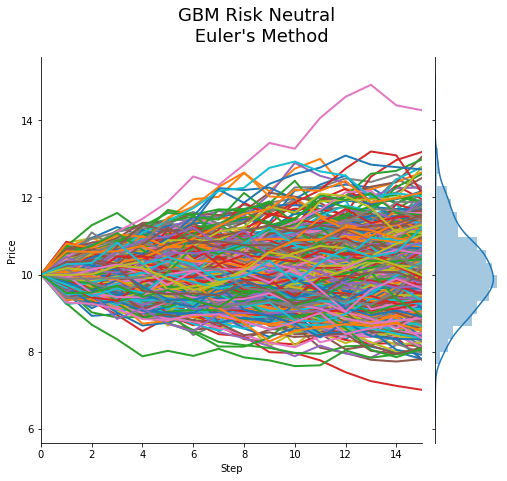

In [25]:
plot_simulations(df,
                 u"GBM Risk Neutral \n Euler's Method",
                 d_param["f_steps"])

In [26]:
# shows statistical summary of the last value (in T) of the simulations
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500.0,10.051192,1.059388,7.013705,9.329898,9.978299,10.683818,14.260906


As I only exchanged $r$ for $\mu $ when modeled by Euler, I just changed the dynamics' drift.

### 3.4. Finally, the pricing of derivatives

Assuming that all options are of the European type (can only be exercised at maturity) and do not depend on the path of the underlying asset, using the risk-neutral world described above, I only need to discount the expected value of the options at maturity. Considering a constant risk-free interest rate of $ r $

$$V_T = e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)]$$

In [27]:
# the basic class for options
import numpy as np

class Derivative(object):
    '''
    A general representation of a Derivative contract. The volatility and the
    interest rate are constant
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K = None):
        '''
        Initialize a Derivative object
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :*param f_K: float. The strike, if applyable
        '''
        # initial parameters
        self.s_name = "General"
        self.f_price = 0
        self.f_delta = 0
        self.f_K = f_K
        self.f_r = f_r
        self.f_sigma = f_sigma
        # define price and delta
        self.update(f_St, f_time)

    def update(self, f_St, f_time):
        '''
        Update the price of the Derivative contract and its Delta
        :param f_St: float. The price of the underlying asset
        :param f_time: float. The time remain until the expiration
        '''
        # save new attributes
        self.f_St = f_St
        self.f_time = f_time
        # calculates price and delta
        self._set_price()
        self._set_delta()
    
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        raise NotImplementedError()

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        raise NotImplementedError()
    
    def __str__(self):
        '''
        Return a string describing the option
        '''
        s = "(a) {} based on an underlying with price {:.2f}"
        s += ", {:.1f}% volatility, interest of {:.1f}%"
        if self.f_K:
            s += ", with Strike {}"
            l_val = [self.s_name, self.f_St, self.f_sigma *100,
                     self.f_r*100, self.f_K, self.f_time,
                     self.f_price, self.f_delta]
        else:
            l_val = [self.s_name, self.f_St, self.f_sigma *100,
                     self.f_r*100, self.f_time, self.f_price,
                     self.f_delta]
        s += " and maturity in {:.2f} years has a price of $ {:.2f}"
        s += " and Delta {:.2f}"
        s = s.format(*l_val)
        return s
        

In [28]:
import pandas as pd

def plot_payoff(MyOption, d_param):
    '''
    PLot the payoff of the option at the expiration
    :param MyOption: Derivative Object. A contract/option instance
    :param d_param: dict. The initial parameter pof the MyOption
    '''
    # calculates Price on expiry
    option = MyOption(**d_param)
    f_min = d_param["f_St"]*0.2
    f_max = d_param["f_St"]*1.8
    na_ST = np.linspace(f_min, f_max, 50)
    l_price = []
    for f_p in na_ST:
        # at expiration
        option.update(f_p, 0.)
        l_price.append(option.f_price)
    # adta wrangling
    df_plot = pd.DataFrame(l_price, index=na_ST)
    df_plot.columns = ["Price"]
    # plot price
    ax = df_plot.plot(legend=False)
    ax.set_xlabel("Underlying Price")
    ax.set_ylabel("PnL")
    s_title = "Pay-Off at Maturity {} {}\n"
    s_prep = "of"
    if "Option" in option.s_name or "Call" in option.s_name:
        s_prep = "is" 
    ax.set_title(s_title.format(s_prep, option.s_name), fontsize=18);

#### 3.4.1 Log Contract

Applying the formula above and the risk-neutral dynamics of the underlying asset to the payoff of the **log price**, it follows that

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = ln(S_T) \\
V_t &= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[ln(S_T)] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[ln(S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}})] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}]
\end{aligned}
\end{equation}

Since $ \mathbb{E}^{\tilde{P}}_t[\tilde{W_t}] = 0 $, the pricing equation and the delta of the option (its sensitivity in relation to $ S_t $) are

\begin{equation}
\begin{aligned}
V_t &= e^{-r(T-t)} \cdot (ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))\\
\Delta &= \frac{\partial V_t}{\partial S_t} = \frac{e^{-r(T-t)}}{S_t}
\end{aligned}
\end{equation}


In [29]:
class LogContract(Derivative):
    '''
    A representation of a Log Contract
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K=None):
        '''
        Initialize a LogContract object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :*param f_K: float. The strike, if applyable
        '''
        # initialize paramters
        super(LogContract, self).__init__(f_St=f_St,
                                          f_sigma=f_sigma,
                                          f_time=f_time,
                                          f_r=f_r,
                                          f_K=None)
        self.s_name = "Derivative Log"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        exp_r_t = np.exp(-1*self.f_r*self.f_time)
        ln_S = np.log(self.f_St)
        r_var_t = (self.f_r - (self.f_sigma**2)/2) * self.f_time
        ln_S_r_var_t = ln_S + r_var_t
        self.f_price = exp_r_t * ln_S_r_var_t

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        exp_r_t = np.exp(-1*self.f_r*self.f_time)
        
        self.f_delta = exp_r_t / self.f_St
    

In [30]:
d_param = {"f_St": 100.,  # initial state of the asset
           "f_r": 0.10,  # interest rate
           "f_sigma": 0.50,  # standard deviation for dynamics
           "f_time": 0.5,  # time elapsed in the simulation
           "f_K": None  # strike(no log)
           }

# code test
x = LogContract(**d_param)
print(x)

(a) Derivative Log based on an underlying with price 100.00, 50.0% volatility, interest of 10.0% and maturity in 0.50 years has a price of $ 4.37 and Delta 0.01


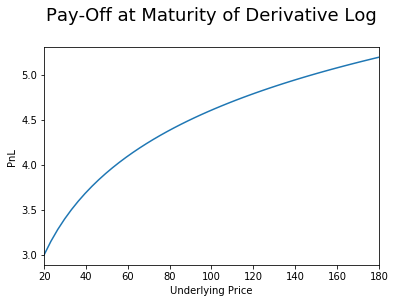

In [31]:
plot_payoff(LogContract, d_param)

#### 3.4.2 Squared Log Contract

Pricing:

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = (ln(S_T))^2 \\
V_t &= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[(ln(S_T))^2] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[(ln(S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}))^2] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t})^2]
\end{aligned}
\end{equation}

Thus,

\begin{equation}
\begin{aligned}
V_t &= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))^2 + 2 \cdot ln(S_t)  \\ 
& \qquad \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) \cdot \sigma \cdot W^{\tilde{P}}_{T-t} + (\sigma \cdot W^{\tilde{P}}_{T-t})^2]
\end{aligned}
\end{equation}

As $ \mathbb{E}^{\tilde{P}}_t[\tilde{W_t}] = 0 $ and $ E^{\tilde{P}}_t[\sigma^2\tilde{W_t}^2] = \sigma^2(Tt)$, so the equation and delta are:

\begin{equation}
\begin{aligned}
V_t &= e^{-r(T-t)} \cdot [(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))^2 + \sigma^2 (T-t)]\\
\Delta &= \frac{\partial V_t}{\partial S_t} = \frac{2e^{-r(T-t)}}{S_t}[(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t)]
\end{aligned}
\end{equation}


In [32]:
class SquaredLogContract(Derivative):
    '''
    A representation of a Squared Log Contract
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K=None):
        '''
        Initialize a SquaredLogContract object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :*param f_K: float. The strike, if applyable
        '''
        # initialize paramters
        super(SquaredLogContract, self).__init__(f_St=f_St,
                                                 f_sigma=f_sigma,
                                                 f_time=f_time,
                                                 f_r=f_r,
                                                 f_K=None)
        self.s_name = "Option Squared Log"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        exp_r_t = np.exp(-1*self.f_r*self.f_time)
        ln_S_r_var_t_sq = (np.log(self.f_St) + (self.f_r - (self.f_sigma**2)/2)
                           * self.f_time)**2
        var_t = self.f_sigma**2 * self.f_time
        self.f_price = exp_r_t * (ln_S_r_var_t_sq + var_t)

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        two_exp_r_t_over_S = 2 * np.exp(-1*self.f_r*self.f_time) / self.f_St
        ln_S_r_var_t = (np.log(self.f_St) + (self.f_r - (self.f_sigma**2)/2)
                        * self.f_time)
        self.f_delta = two_exp_r_t_over_S * ln_S_r_var_t

In [33]:
# parametros iniciais
d_param = {"f_St": 100.,  # initial state of the asset
           "f_r": 0.10,  # interest rate
           "f_sigma": 0.50, # standard deviation for dynamics
           "f_time": 0.5, # time elapsed in the simulation
           "f_K": None  # strike(no log)
           }

# code test
x = SquaredLogContract(**d_param)
print(x)

(a) Option Squared Log based on an underlying with price 100.00, 50.0% volatility, interest of 10.0% and maturity in 0.50 years has a price of $ 20.18 and Delta 0.09


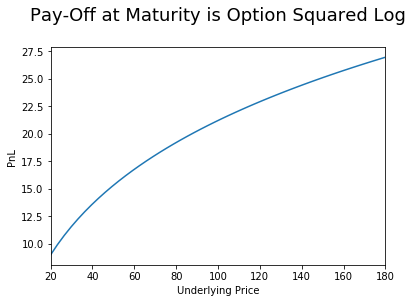

In [34]:
plot_payoff(SquaredLogContract, d_param)

#### 3.4.3 Squared Log Contract

For an **exotic option** with a payoff $V(T, S_T)=(S_T-K)^2$, adn strike price $K$:

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = (S_T-K)^2 = S_T^2 - 2K S_T + K^2\\
V_t &= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[S_T^2 - 2K S_T + K^2] \\
&= e^{-r(T-t)} (\mathbb{E}^{\tilde{P}}_{t}[S_T^2] - 2KE^{\tilde{P}}_{t}[S_T] + K^2) \\
\end{aligned}
\end{equation}

Remembering that given $X \sim N(\mu, \sigma)$, its moment-generating function is of the form $\mathbb{E}_{t}^{\tilde{P}}(e^{\lambda X}) = e^{\lambda \mu + \tfrac{1}{2} \lambda^{2} \sigma^{2}}$:

\begin{equation}
\begin{aligned}
\mathbb{E}^{\tilde{P}}_{t}[S_T] &= S_t  \cdot \mathbb{E}^{\tilde{P}}_{t}[e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}]\\
&= S_t  \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \frac{\sigma^2}{2}(T - t)} \\
&= S_t  \cdot e^{r(T-t)}
\end{aligned}
\end{equation}

Then

\begin{equation}
\begin{aligned}
\mathbb{E}^{\tilde{P}}_{t}[S_T^2] &= S_t^2  \cdot e^{ 2(r - \frac{\sigma^2}{2} ) \cdot (T - t) + \frac{4 \sigma^2}{2}(T - t)} \\
&= S_t^2  \cdot e^{(2r + \sigma^2)(T-t)}
\end{aligned}
\end{equation}

Therefore, the contract's pricing equation (which has a $ K $ already fixed) and its delta are given by:

\begin{equation}
\begin{aligned}
V_t &= e^{-r(T-t)} (\mathbb{E}^{\tilde{P}}_{t}[S_T^2] - 2KE^{\tilde{P}}_{t}[S_T] + K^2) \\
&= e^{-r(T-t)} (S_t^2  \cdot e^{(2r + \sigma^2)(T-t)} - 2KS_t  \cdot e^{r(T-t)} + K^2) \\
&=  S_t^2  \cdot e^{(r + \sigma^2)(T-t)} - 2KS_t + K^2 e^{-r(T-t)} \\
\Delta &= \frac{\partial V_t}{\partial S_t} = 2 S_t  \cdot e^{(r + \sigma^2)(T-t)} - 2K
\end{aligned}
\end{equation}


In [35]:
class SquaredExotic(Derivative):
    '''
    A representation of a exotic suqared contract. The Strike is given
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K):
        '''
        Initialize a SquaredExotic object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param f_K: float. The strike, if applyable
        '''
        # initialize parameters
        super(SquaredExotic, self).__init__(f_St=f_St,
                                            f_sigma=f_sigma,
                                            f_time=f_time,
                                            f_r=f_r,
                                            f_K=f_K)
        self.s_name = "Exotic Squared"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        exp_r_var_t = np.exp((self.f_r + self.f_sigma**2)*self.f_time)
        S_sq_exp_r_var_t = self.f_St**2 * exp_r_var_t
        K_sq_exp_r_t = self.f_K**2 * np.exp(-self.f_r * self.f_time)
        two_S_K = 2 * self.f_St * self.f_K
        self.f_price = S_sq_exp_r_var_t - two_S_K + K_sq_exp_r_t

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        exp_r_var_t = np.exp((self.f_r + self.f_sigma**2)*self.f_time)
        two_K = 2 * self.f_K

        self.f_delta = 2*self.f_St * exp_r_var_t - two_K

In [36]:
d_param = {"f_St": 100.,  # initial state of the asset
           "f_r": 0.10,  # interest rate
           "f_sigma": 0.50,  # standard deviation for dynamics
           "f_time": 0.5,  # time elapsed in the simulation (years)
           "f_K": 100  # # strike(no square)
           }
# code test
x = SquaredExotic(**d_param)
print(x)

(a) Exotic Squared based on an underlying with price 100.00, 50.0% volatility, interest of 10.0%, with Strike 100 and maturity in 0.50 years has a price of $ 1424.76 and Delta 38.25


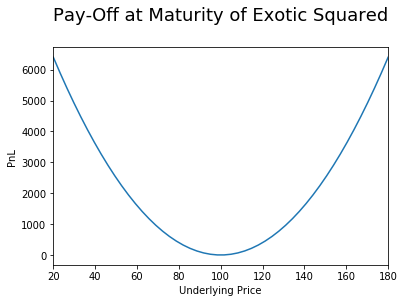

In [37]:
plot_payoff(SquaredExotic, d_param)

#### 3.4.4 Digital Option (Cash or Nothing)

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = \mathbf{1}_{S_T > K} \\
V_t &= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[\mathbf{1}_{S_T > K}] \\
\end{aligned}
\end{equation}

For $S_T>K$

\begin{equation}
\begin{aligned}
S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}} &> K\\
\sigma \cdot W^{\tilde{P}}_{T-t} &> ln(\frac{K}{S_T}) - (r - \frac{\sigma^2}{2} ) \cdot (T - t) \\
- \frac{W^{\tilde{P}}_{T-t}}{\sqrt{T-t}} &< \left [ ln(\frac{S_T}{K}) - (r - \frac{\sigma^2}{2} ) \cdot (T - t) \right ] \cdot \frac{1}{(\sigma \sqrt{T-t})}
\end{aligned}
\end{equation}

Thus,

\begin{equation}
\begin{aligned}
e^{-r(T-t)} \mathbb{E}^{\tilde{P}}_{t}[\mathbf{1}_{S_T > K}] &= e^{-r(T-t)} Prob^{\tilde{P}}(S_T>K) = e^{-r(T-t)} Prob^{\tilde{P}}(\xi < d2)\\
V_T &= e^{-r(T-t)} N(d2) \\
\Delta &=\frac{e^{-r(T-t)} N'(d_2)}{\sigma S_t \sqrt{T-t}}
\end{aligned}
\end{equation}

Where $ N(.) $ Is the CDF of a standard normal and $ N'(.) $ is the PDF. The derivation of the delta can be found on (http://quant.stackexchange.com/questions/23267/delta-of-binary-option). It is interesting to note that at maturity, as will be seen in the payoff chart below, the option is not differentiable.

In [38]:
def get_d1_and_d2(f_St, f_sigma, f_time, f_r, f_K):
    '''
    Calculate the d1 and d2 parameter used in Digital and call options
    '''
    f_d2 = (np.log(f_St/f_K) - (f_r - 0.5 * f_sigma **2)*f_time)
    f_d2 /= (f_sigma * f_time**0.5)
    f_d1 = f_d2 + f_sigma*f_time**0.5
    return f_d1, f_d2

In [39]:
from scipy import stats

class DigitalOption(Derivative):
    '''
    A representation of a Digital Option.
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K):
        '''
        Initialize a DigitalOption object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param f_K: float. The strike, if applyable
        '''
        # initiate parameters
        super(DigitalOption, self).__init__(f_St=f_St,
                                            f_sigma=f_sigma,
                                            f_time=f_time,
                                            f_r=f_r,
                                            f_K=f_K)
        self.s_name = "Digital Option"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        exp_r_t = np.exp(-self.f_r * self.f_time)
        cdf_d2 = stats.norm.cdf(f_d2, 0., 1.)
        self.f_price = exp_r_t * cdf_d2

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        exp_r_t = np.exp(-self.f_r * self.f_time)
        pdf_d2 = stats.norm.pdf(f_d2, 0., 1.)
        sig_S_sqtr_t = self.f_sigma * self.f_St * (self.f_time**0.5)
        self.f_delta = exp_r_t * pdf_d2 / sig_S_sqtr_t

In [40]:
d_param = {"f_St": 100.,  # initial state of the asset
           "f_r": 0.10,  # interest rate
           "f_sigma": 0.50,  # standard deviation for dynamics
           "f_time": 0.5,  # time elapsed in the simulation (years)
           "f_K": 100  # strike
           }
# code test
x = DigitalOption(**d_param)
print(x)

(a) Digital Option based on an underlying with price 100.00, 50.0% volatility, interest of 10.0%, with Strike 100 and maturity in 0.50 years has a price of $ 0.49 and Delta 0.01


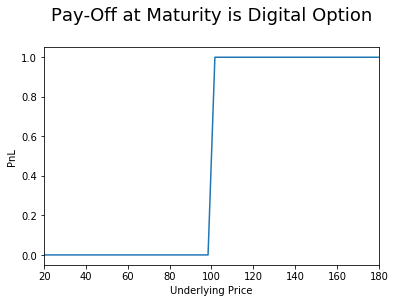

In [37]:
plot_payoff(DigitalOption, d_param)

**PDE Method**

In [49]:
# PDE
K = d_param["f_K"]
Nspace = 6000   # M space steps
Ntime = 5000    # N time steps 
X0 = np.log(d_param["f_St"])
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0, d_param["f_time"], Ntime, retstep=True)       # time discretization
Payoff = np.where(np.exp(x)>d_param["f_K"], 1, 0)          # Binary payoff

V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = 1                        # boundary condition
V[0,:] = 0                         # boundary condition

# construction of the tri-diagonal matrix D
sig2 = d_param["f_sigma"]*d_param["f_sigma"]; dxx = dx * dx
a = ( (dt/2) * ( (d_param["f_r"]-0.5*d_param["f_sigma"])/dx - d_param["f_sigma"]/dxx ) )
b = ( 1 + dt * ( d_param["f_sigma"]/dxx + d_param["f_r"] ) )
c = (-(dt/2) * ( (d_param["f_r"]-0.5*d_param["f_sigma"])/dx + d_param["f_sigma"]/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = DD.solve(V[1:-1,i+1] - offset)     

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print("The price of the ATM digital call option by PDE is: ", oPrice)

The price of the ATM digital call option by PDE is:  0.4191247761148442


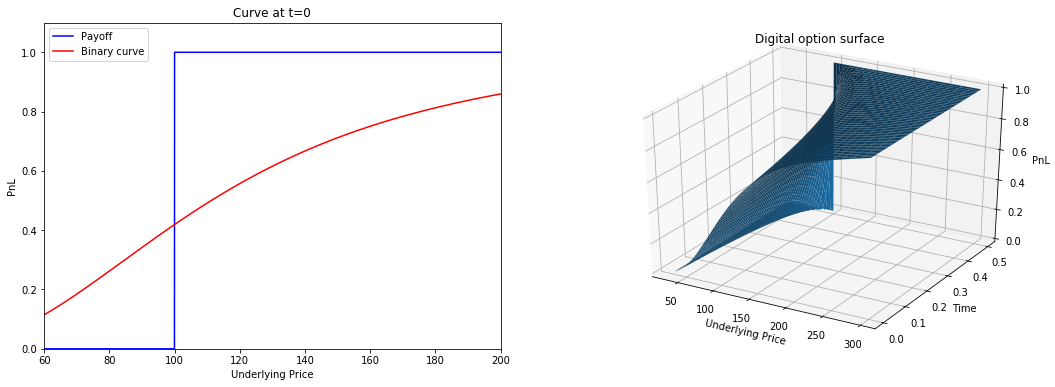

In [52]:
S = np.exp(x)
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="Binary curve")
ax1.set_xlim(60,200); ax1.set_ylim(0,1.1)
ax1.set_xlabel("Underlying Price"); ax1.set_ylabel("PnL"); ax1.legend(loc='upper left')
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Digital option surface"); ax2.set_xlabel("Underlying Price"); ax2.set_ylabel("Time"); ax2.set_zlabel("PnL")
plt.show()

#### 3.4.5 European Call Option

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = max(S_T-K, 0) \\
&= (S_T-K)\mathbf{1}_{S_T > K} \\
&= S_T\mathbf{1}_{S_T > K}-K\mathbf{1}_{S_T > K} \\
\end{aligned}
\end{equation}

The second term, $ K \mathbf{1}_{S_T> K}$, is equivalent to the payoff of a digital option multiplied by K. The first term is equivalent to the payoff of the *equity or nothing digital option*, which will not be shown here, however, for an asset that does not pay dividends, it is of the form $S_T N(d1)$. Where $d1$ can be shown as $ d1 = d2 + \sigma \sqrt{(T-t)} $. Thus, the pricing formula and the delta are

\begin{equation}
\begin{aligned}
V_T &= S_T  N(d1)- K e^{-r(T-t)} N(d2) \\
\Delta &= \frac{\partial V_t}{\partial S_t} = N(d1)
\end{aligned}
\end{equation}

In [38]:
class EuropeanCall(Derivative):
    '''
    A representation of a European Call Option
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K):
        '''
        Initialize a EuropeanCall object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param f_K: float. The strike, if applyable
        '''
        # initialize parameters
        super(EuropeanCall, self).__init__(f_St=f_St,
                                            f_sigma=f_sigma,
                                            f_time=f_time,
                                            f_r=f_r,
                                            f_K=f_K)
        self.s_name = "European Call"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        exp_r_t = np.exp(-self.f_r * self.f_time)
        S_cdf_d1 = self.f_St * stats.norm.cdf(f_d1, 0., 1.)
        K_cdf_d2 = self.f_K * stats.norm.cdf(f_d2, 0., 1.)
        
        self.f_price = S_cdf_d1 - K_cdf_d2 * exp_r_t

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        cdf_d1 = stats.norm.cdf(f_d1, 0., 1.)
        self.f_delta = cdf_d1

In [39]:
d_param = {"f_St": 100.,  # initial state of the asset
           "f_r": 0.10, # interest rate
           "f_sigma": 0.50,  # standard deviation for dynamics
           "f_time": 0.5,  # time elapsed in the simulation (years)
           "f_K": 100  # strike price
           }

# code test
x = EuropeanCall(**d_param)
print(x)

(a) European Call based on an underlying with price 100.00, 50.0% volatility, interest of 10.0%, with Strike 100 and maturity in 0.50 years has a price of $ 16.23 and Delta 0.65


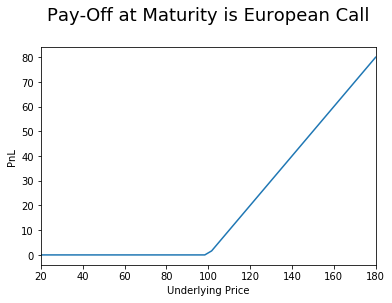

In [40]:
plot_payoff(EuropeanCall, d_param)

## 4. Replicating the Portfolio

As stated in section one, the intention here is to implement a dynamic, self-financing hedging strategy that replicates the payoff of a given derivative. Thus, the value of a $\Pi_t $ portfolio can be written as

$$\Pi_t = \Delta(S_t, t) S_t + \varphi (S_t, t) B_t$$

Where $ \Delta(S_t, t) $ is the amount applied to the underlying at a given price $ S_t $ at the time $ t $. Therefore $ \Delta(S_t, t) S_t $ is the monetary value applied to the underlying. The same logic follows $ \varphi(S_t, t) $, which is the amount invested in a risk-free asset(in a *Bond*, for example). The $ \varphi(S_t, t)B_t $ corresponds to the monetary value taken or applied at the risk-free rate (*money market account*). Since this portfolio is meant to be equal to the value of the derivative, we compute

\begin{equation}
\begin{aligned}
V_t &= \Pi_t \\
V_t &= \Delta(S_t, t) S_t + \varphi (S_t, t) \cdot B_t \\
\end{aligned}
\end{equation}

The first application will be of the form:

$$B_t\varphi (S_t, t) = V_t - \Delta(S_t, t) S_t$$

However, after the first application, it is expected that the updates will be of the form:

$$B_t\varphi (S_{t+1}, t+1) = B_t\varphi (S_t, t)(1+r\delta_t) - \Delta(S_{t+1}, t+1) S_{t+1}$$

In $ T $, the $ \Delta $ used will be the previous one, $ \Delta(S_{T-1}, T-1) $.


In [41]:
def box_plot_err(MyOption, df):
    '''
    Plot a boxplot of the hedging erro of the strategy passed
    '''
    # plot data
    df2 = df.copy()
    df2 = df2.assign(Err=df2['Vt'] - df2['Ht'])
    option = MyOption(1., 1., 1., 1., 1.)
    print(df2)
    ax = sns.boxplot(x='N', y='Err', data=df2)
    ax.set_ylabel('$V_T - H_T$')
    ax.set_xlabel('Number of Rebalancings')
    # define titles
    s_title = 'Replication Hedging Error Box-Plot \n'
    s_prep = 'of'
    if 'Option' in option.s_name or 'Call' in option.s_name:
        s_prep = 'is'
    # title
    ax.set_title(s_title, fontsize=16, y=1.03)

In [42]:
def plot_payoff_all_simulations(MyOption, df):
    '''
    Plot a payoff scatter plot with the final returns of a stochastic
    simulation of a replicationg strategy using different rebalancing
    frequencies. Compare to the last price of the option/contract simulated
    :param MyOption: Derivative Object. A contract/option instance
    :param df: dataframe. The output of strategy the simulation
    '''
    # excludes asset values that are in the top 2% of the distribution
    f_98perc = np.percentile(df.St, 98)
    df2 = df[(df.St <= f_98perc)]
    f_max = df2.St.max()
    option = MyOption(1., 1., 1., 1., 1.)
    
    # plot graph
    g = sns.FacetGrid(df2, col="N", col_wrap=3, margin_titles=True,
                      sharex=False, size=3, aspect=1.3)
    g.map(plt.scatter, 'St', 'Ht', s=2, linewidth=.0, edgecolor='white',
          alpha=0.6, label=u'$H(T)$')
    g.map(plt.scatter, 'St', 'Vt', s=3, linewidth=.0, edgecolor='white',
          color='g', label=u'$V(T)$')
    # define titles
    s_title = u'Pay-Off of Simulation {} {}\n'
    s_prep = 'of'
    if 'Option' in option.s_name or 'Call' in option.s_name:
        s_prep = 'is'
    g.fig.suptitle(s_title.format(s_prep, option.s_name), fontsize=16, y=1.03)
    g.despine(left=True).add_legend()
    g.set(xlim=(5., f_max + 5))

In [43]:
import time

def replicate_portfolio(i_nsiml, MyOption, d_param):
    '''
    Simulate portfolio when selling a given option/contract and using a
    money market account and the the underline asset to replicate it
    Return a dataframe with the last observed value of the derivative,
    de asset and the strategy
    :param MyOption: Derivative Object. A contract/option instance
    :param i_nsiml: integer. the number of paths contructed
    :param d_param: dictionary. The parameter of the simulation
    '''
    st = time.time()
    # create object for simulation
    gbm = GBM_By_Euler(f_s0=d_param['f_St'],
                       f_mu=d_param['f_mu'],
                       f_sigma=d_param['f_sigma'],
                       f_time=d_param['f_time'],
                       f_steps=d_param['f_steps'])
    # create dictionary for options
    d_par_opt = {'f_St': d_param['f_St'],
                 'f_r': d_param['f_r'],
                 'f_sigma': d_param['f_sigma'],
                 'f_time': d_param['f_time'],
                 'f_K': d_param['f_K']
                 }
    # create option
    option = MyOption(**d_par_opt)
    f_dt = d_param['f_time'] / d_param['f_steps']
    
    #create i_nsiml paths with f_steps simulations and calculation
    # calculate the deltas and phis in each step
    d = {'St': [], 'Vt': [], 'Delta': [],
         'PhiB': [], 'DeltaS': [], 'Ht': []}
    d_aux = {'St': [], 'Vt': [], 'Delta': [],
             'PhiB': [], 'DeltaS': [], 'Ht': []}
    for idx in range(int(i_nsiml * (1 + gbm.f_steps))):
        if gbm.current_step == gbm.f_steps:
            
            # finished this path. Starts another
            for s_key in ['St', 'Vt', 'Delta', 'PhiB', 'DeltaS', 'Ht']:
                # d[s_key].append(d_aux[s_key])
                d[s_key].append(d_aux[s_key][-1])
                d_aux[s_key] = []
        
        d_aux['St'].append(gbm())
        
        # calculate time to maturity
        f_tnow = d_param['f_time'] - gbm.current_step*f_dt
        
        # option price calculation
        option.update(d_aux['St'][-1], f_tnow)
        d_aux['Vt'].append(option.f_price)
        
        # treats delta value when asset expires
        if f_tnow < 10e-6:
            option.f_delta = d_aux['Delta'][-1]
        
        # keep delta value
        d_aux['Delta'].append(option.f_delta)
        
        # Calculation of asset position for replicating portfolio
        d_aux['DeltaS'].append(d_aux['St'][-1] * d_aux['Delta'][-1])
        
        # calculate value in the money market account
        if gbm.current_step == 0:
            d_aux['PhiB'].append(d_aux['Vt'][-1] - d_aux['DeltaS'][-1])
        else:
            # carry interest from the previous application
            f_aux = d_aux['PhiB'][-1] * (1 + f_dt * d_param['f_r'])
            
            # paid delta hedge
            f_chg_delta = d_aux['Delta'][-1] - d_aux['Delta'][-2]
            f_chg_delta_s = f_chg_delta * d_aux['St'][-1]
            
            # keep value in the money account
            d_aux['PhiB'].append(f_aux - f_chg_delta_s)
        
        # calculate strategy value
        d_aux['Ht'].append(d_aux['DeltaS'][-1] + d_aux['PhiB'][-1])

    # keep last path
    for s_key in ['St', 'Vt', 'Delta', 'PhiB', 'DeltaS', 'Ht']:
        # d[s_key].append(d_aux[s_key])
        d[s_key].append(d_aux[s_key][-1])
        d_aux[s_key] = []

    # print time and simulations and set up table
    print ('\n Number: {}'.format(idx + 1))
    print ('It took {:0.2f} seconds'.format(time.time() - st))
    # create dataframe with steps in rows and simulations in columns
    df = pd.DataFrame(d)
    df = df.loc[:, ['St', 'Ht', 'Vt']]
    return df

First, test for **European Call**:

In [44]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,   # initial state of the asset
               "f_r": 0.10,  # interest rate
               "f_sigma": 0.50,  # standard deviation for dynamics
               "f_time": 0.5,  # time elapsed in the simulation (years)
               "f_K": 100,  # strike price
               "f_steps": N, # number of steps taken between a and f_time
               "f_mu": 0.12  # mean of dynamics
               }
    d[N] = replicate_portfolio(i_nsiml, EuropeanCall, d_param)
print("\nTOTAL: {:.2f} seconds".format(time.time() - st))


 Number: 80000
It took 25.67 seconds

 Number: 155000
It took 58.35 seconds

 Number: 265000
It took 112.25 seconds

 Number: 455000
It took 138.29 seconds

 Number: 905000
It took 273.24 seconds

 Number: 1805000
It took 541.80 seconds

TOTAL: 1149.65 seconds


In [50]:
%cd C:\projects\python\Dynamic Hedging Derivatives

C:\projects\python\Dynamic Hedging Derivatives


In [51]:
# save results
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/european_call.tsv", sep="\t")

In [52]:
df.head()

,St,Ht,Vt,N
0,108.670674,12.810911,8.670674,15
1,100.252474,6.157147,0.252474,15
2,56.703613,-6.623493,0.000000,15
3,107.058730,11.957214,7.058730,15
4,84.866558,-3.345734,0.000000,15


Below I will plot the payoff graphs for the strategy using various rebalancing frequencies. As can be seen, the amount of rebalancing reduces the hedging error of the strategy.

In [53]:
df = pd.read_csv("data/european_call.tsv", sep="\t")

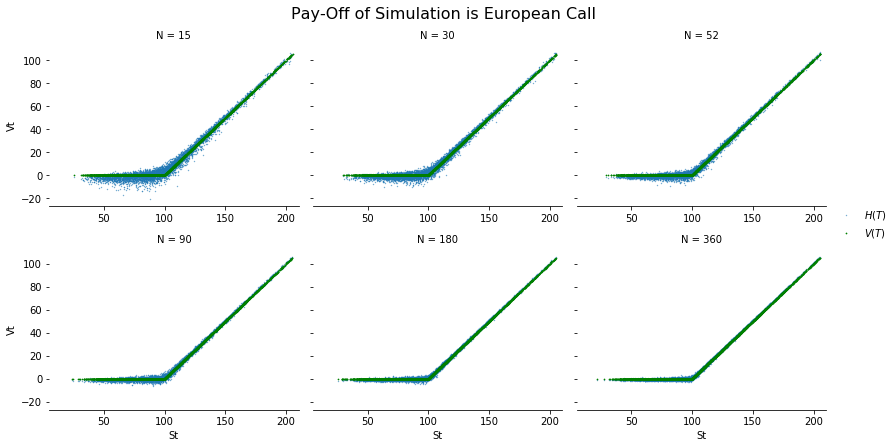

In [54]:
plot_payoff_all_simulations(EuropeanCall, df);

Another way to visualize this data is through boxplots of the distribution of the results of each rebalancing. The "box" marks the second and third quartiles, while the "shadow" marks the first and fourth quartiles (calculated using the interquartile range.

       Unnamed: 0          St         Ht         Vt    N       Err
0               0  108.670674  12.810911   8.670674   15 -4.140237
1               1  100.252474   6.157147   0.252474   15 -5.904674
2               2   56.703613  -6.623493   0.000000   15  6.623493
3               3  107.058730  11.957214   7.058730   15 -4.898484
4               4   84.866558  -3.345734   0.000000   15  3.345734
...           ...         ...        ...        ...  ...       ...
29995       29995  155.910064  56.331437  55.910064  360 -0.421373
29996       29996   91.398661  -0.288033   0.000000  360  0.288033
29997       29997  153.803176  55.684961  53.803176  360 -1.881786
29998       29998  132.861874  33.254837  32.861874  360 -0.392962
29999       29999   86.661675   0.804392   0.000000  360 -0.804392

[30000 rows x 6 columns]


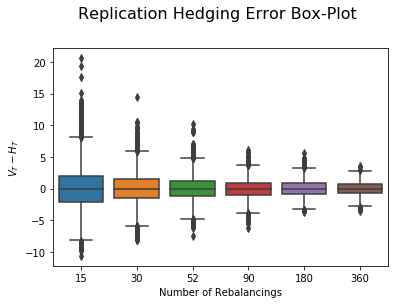

In [55]:
box_plot_err(EuropeanCall, df)

Now testing for the **Log Contract**:

In [57]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,   # initial state of the asset
               "f_r": 0.10,  # interest rate
               "f_sigma": 0.50,  # standard deviation for dynamics
               "f_time": 0.5,  # time elapsed in the simulation (years)
               "f_K": 100,  # strike price
               "f_steps": N, # number of steps taken between a and f_time
               "f_mu": 0.12  # mean of dynamics
               }
    d[N] = replicate_portfolio(i_nsiml, LogContract, d_param)
print("\nTOTAL: {:.2f} seconds".format(time.time() - st))


 Number: 80000
It took 1.52 seconds

 Number: 155000
It took 3.58 seconds

 Number: 265000
It took 4.69 seconds

 Number: 455000
It took 8.32 seconds

 Number: 905000
It took 27.51 seconds

 Number: 1805000
It took 88.44 seconds

TOTAL: 134.14 seconds


In [58]:
# save results
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/log_contract.tsv", sep="\t")

In [59]:
df.head()

,St,Ht,Vt,N
0,47.273914,3.878873,3.855959,15
1,154.762817,5.033880,5.041894,15
2,78.693969,4.360277,4.365567,15
3,128.519649,4.892653,4.856082,15
4,99.212350,4.589757,4.597263,15


Plot the payoffs (rebalancing):

In [60]:
df = pd.read_csv("data/log_contract.tsv", sep="\t")

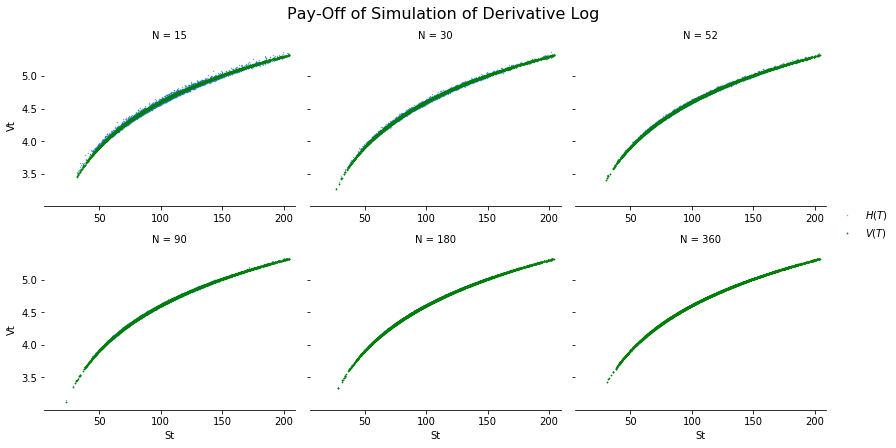

In [61]:
plot_payoff_all_simulations(LogContract, df)

The distributions:

       Unnamed: 0          St        Ht        Vt    N       Err
0               0   47.273914  3.878873  3.855959   15 -0.022914
1               1  154.762817  5.033880  5.041894   15  0.008014
2               2   78.693969  4.360277  4.365567   15  0.005290
3               3  128.519649  4.892653  4.856082   15 -0.036571
4               4   99.212350  4.589757  4.597263   15  0.007506
...           ...         ...       ...       ...  ...       ...
29995       29995  116.376272  4.763302  4.756829  360 -0.006473
29996       29996  144.014479  4.973222  4.969914  360 -0.003308
29997       29997   60.653418  4.106863  4.105176  360 -0.001687
29998       29998  102.678300  4.630626  4.631601  360  0.000975
29999       29999   78.211488  4.361691  4.359417  360 -0.002274

[30000 rows x 6 columns]


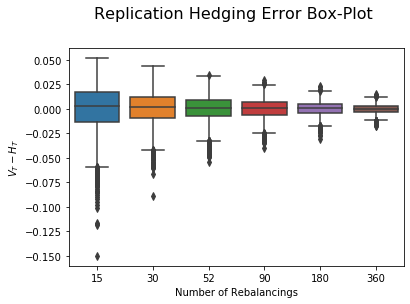

In [62]:
box_plot_err(LogContract, df)

Now, testing for **Exotic Squared Log Contract**:

In [64]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,   # initial state of the asset
               "f_r": 0.10,  # interest rate
               "f_sigma": 0.50,  # standard deviation for dynamics
               "f_time": 0.5,  # time elapsed in the simulation (years)
               "f_K": 100,  # strike price
               "f_steps": N, # number of steps taken between a and f_time
               "f_mu": 0.12  # mean of dynamics
               }
    
    d[N] = replicate_portfolio(i_nsiml, SquaredLogContract, d_param)
print("\n TOTAL: {:.2f} seconds".format(time.time() - st))


 Number: 80000
It took 3.48 seconds

 Number: 155000
It took 5.20 seconds

 Number: 265000
It took 26.65 seconds

 Number: 455000
It took 67.88 seconds

 Number: 905000
It took 93.41 seconds

 Number: 1805000
It took 53.81 seconds

 TOTAL: 250.64 seconds


In [65]:
# save results
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/sqr_log_contract.tsv", sep="\t")

In [66]:
df.head()

,St,Ht,Vt,N
0,126.688514,23.176520,23.442363,15
1,86.535891,19.724348,19.896589,15
2,68.004038,18.081084,17.804746,15
3,101.634600,21.203491,21.357190,15
4,118.852470,22.608640,22.828166,15


The payoffs are:

In [67]:
df = pd.read_csv("data/sqr_log_contract.tsv", sep="\t")

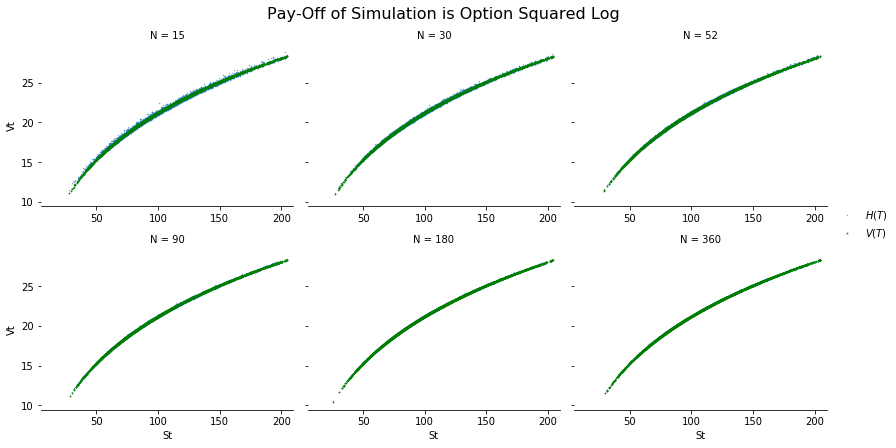

In [68]:
plot_payoff_all_simulations(SquaredLogContract, df);

And boxplots:

       Unnamed: 0          St         Ht         Vt    N       Err
0               0  126.688514  23.176520  23.442363   15  0.265843
1               1   86.535891  19.724348  19.896589   15  0.172241
2               2   68.004038  18.081084  17.804746   15 -0.276338
3               3  101.634600  21.203491  21.357190   15  0.153699
4               4  118.852470  22.608640  22.828166   15  0.219526
...           ...         ...        ...        ...  ...       ...
29995       29995   71.820534  18.265470  18.268533  360  0.003063
29996       29996   73.936504  18.497912  18.517588  360  0.019676
29997       29997   57.671080  16.486330  16.441045  360 -0.045285
29998       29998  151.207364  25.174079  25.186870  360  0.012791
29999       29999  124.964665  23.305726  23.309884  360  0.004158

[30000 rows x 6 columns]


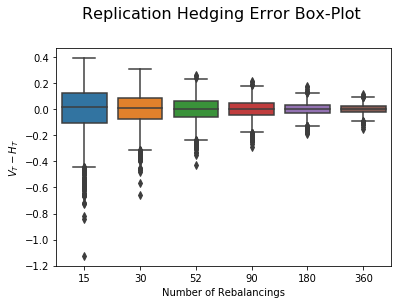

In [69]:
box_plot_err(SquaredLogContract, df)

Test for exotic square option:

In [71]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,   # initial state of the asset
               "f_r": 0.10,  # interest rate
               "f_sigma": 0.50,  # standard deviation for dynamics
               "f_time": 0.5,  # time elapsed in the simulation (years)
               "f_K": 100,  # strike price
               "f_steps": N, # number of steps taken between a and f_time
               "f_mu": 0.12  # mean of dynamics
               }
    d[N] = replicate_portfolio(i_nsiml, SquaredExotic, d_param)
print("\nTOTAL: {:.2f} seconds".format(time.time() - st))


 Number: 80000
It took 2.00 seconds

 Number: 155000
It took 3.27 seconds

 Number: 265000
It took 16.12 seconds

 Number: 455000
It took 36.17 seconds

 Number: 905000
It took 73.76 seconds

 Number: 1805000
It took 138.93 seconds

TOTAL: 270.45 seconds


In [72]:
# save results
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/sqr_exotic.tsv", sep="\t")

In [73]:
df.head()

,St,Ht,Vt,N
0,79.727394,554.491254,410.978570,15
1,60.953588,1059.242336,1524.622276,15
2,99.363535,49.405374,0.405088,15
3,94.123019,-112.747322,34.538900,15
4,128.625995,792.415791,819.447577,15


Payoffs:

In [74]:
df = pd.read_csv("data/sqr_exotic.tsv", sep="\t")

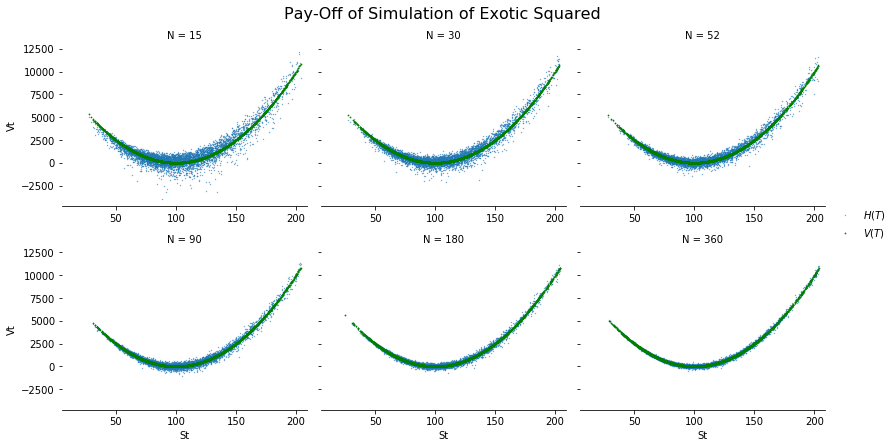

In [75]:
plot_payoff_all_simulations(SquaredExotic, df);

And box plots:

       Unnamed: 0          St           Ht           Vt    N         Err
0               0   79.727394   554.491254   410.978570   15 -143.512685
1               1   60.953588  1059.242336  1524.622276   15  465.379940
2               2   99.363535    49.405374     0.405088   15  -49.000286
3               3   94.123019  -112.747322    34.538900   15  147.286222
4               4  128.625995   792.415791   819.447577   15   27.031786
...           ...         ...          ...          ...  ...         ...
29995       29995   86.521140    58.261289   181.679680  360  123.418391
29996       29996  100.804522    -3.636776     0.647256  360    4.284032
29997       29997   88.886220   127.183737   123.516105  360   -3.667631
29998       29998  156.333337  3183.739059  3173.444896  360  -10.294162
29999       29999  141.671512  1786.071112  1736.514914  360  -49.556199

[30000 rows x 6 columns]


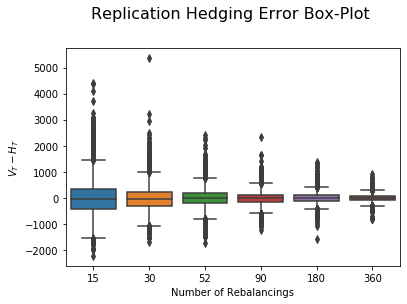

In [76]:
box_plot_err(SquaredExotic, df)

For the **Digital Option**:

In [77]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,   # initial state of the asset
               "f_r": 0.10,  # interest rate
               "f_sigma": 0.50,  # standard deviation for dynamics
               "f_time": 0.5,  # time elapsed in the simulation (years)
               "f_K": 100,  # strike price
               "f_steps": N, # number of steps taken between a and f_time
               "f_mu": 0.12  # mean of dynamics
               }
    d[N] = replicate_portfolio(i_nsiml, DigitalOption, d_param)
print("\n TOTAL: {:.2f} seconds".format(time.time() - st))


 Number: 80000
It took 32.26 seconds

 Number: 155000
It took 63.80 seconds

 Number: 265000
It took 142.10 seconds

 Number: 455000
It took 263.76 seconds

 Number: 905000
It took 416.04 seconds

 Number: 1805000
It took 876.29 seconds

 TOTAL: 1794.35 seconds


In [78]:
# save results
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/digital_opt.tsv", sep="\t")

As can be seen below, even with a large amount of rebalancing, it is not possible to replicate this contract very accurately, especially in the region that shows discontinuity in the graph:

In [79]:
df = pd.read_csv("data/digital_opt.tsv", sep="\t")

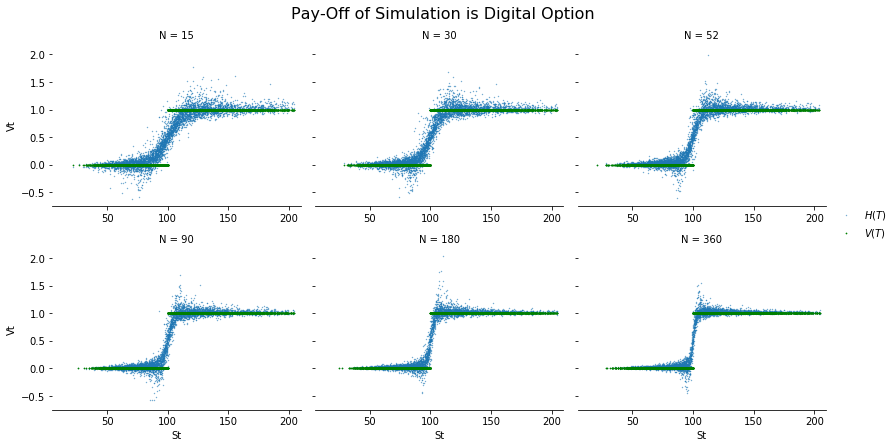

In [80]:
plot_payoff_all_simulations(DigitalOption, df)

The strategy difference boxplot for the derivative price:

       Unnamed: 0          St        Ht   Vt    N       Err
0               0  163.810881  0.998583  1.0   15  0.001417
1               1  145.531136  0.916082  1.0   15  0.083918
2               2   62.254453 -0.065671  0.0   15  0.065671
3               3  122.460262  1.062939  1.0   15 -0.062939
4               4   98.108210  0.330395  0.0   15 -0.330395
...           ...         ...       ...  ...  ...       ...
29995       29995  116.962109  1.011604  1.0  360 -0.011604
29996       29996  103.016830  1.047030  1.0  360 -0.047030
29997       29997  126.958856  1.039944  1.0  360 -0.039944
29998       29998   87.567306  0.153994  0.0  360 -0.153994
29999       29999   76.443525  0.011612  0.0  360 -0.011612

[30000 rows x 6 columns]


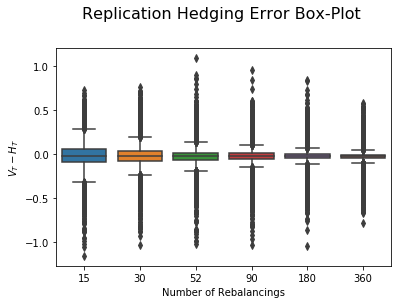

In [81]:
box_plot_err(DigitalOption, df)

## 5. Conclusion

In this small project, a strategy was implemented to replicate the value of several derivatives based on an asset that follows a Brownian Geometric Movement. The strategy, a self-financing dynamic hedging, is the centerpiece of the Black-Scholes model and, therefore, all its assumptions and limitations are also applicable here.

One of these assumptions, that the strategy can be hedged continuously, was tested when I used different rebalancing levels. As seen, the more the frequency of hedgings increases, the closer we get to the final payoff of the option. However, even disregarding operating costs, this strategy has limitations, as I was able to verify the replication of the Digital Option.

## 6. Last Considerations

When I coded the stochastic processes, I decided to draw one value at a time. I did this to make it easier to debug the results and I thought that would not be a problem, which in most cases was not, in fact. However, when I simulated the random paths with the *European Call* and *Digital* options, the simulation was very slow. I believe that this has more to do with the use of *PDF*s and *CDF*s in the calculations that relate to the way I implemented it. However, it would be interesting to investigate this inefficiency in the future.